## This example is based on article: "Extraction pf DFB Laser Rate Equation Parameters for System Simulation Purposes" by John C. Cartledge and R. C. Srinivasan.

In [1]:
import matplotlib.pyplot as plt
import random
import numpy as np
import scipy.signal as signal
from scipy.ndimage import shift
from tqdm.notebook import tqdm

In [2]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import optic.models.laser as laser

In [3]:
from commpy.utilities  import upsample
from optic.dsp.core import firFilter, pulseShape
from optic.utils import parameters

In [4]:
from IPython.core.display import HTML
from IPython.core.pylabtools import figsize

HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [5]:
figsize(9,6)
plt.style.use('bmh')

## Simulation - Cartledge (JLT, vol. 15, no. 15, 852-860, 1997)

In [6]:
laser_dfb_parameters = parameters()
# Use parameters from Table II - bias current = 35 mA
laser_dfb_parameters.noise_terms = False
laser_dfb_parameters.v       = 1.98e-11  # [cm3]  active layer volume
laser_dfb_parameters.tau_n   = 0.76e-9   # [s]    electron lifetime
laser_dfb_parameters.a0      = 2.5e-16   # [cm2]  active layer gain coefficient
laser_dfb_parameters.vg      = 6.36e+9   # [cm/s] group velocity
laser_dfb_parameters.n_t     = 1.0e18    # [cm-1] carrier density at transparency
laser_dfb_parameters.epsilon = 1.48e-17  # [cm3] gain compression factor
laser_dfb_parameters.tau_p   = 0.79e-12  # [s] photon lifetime
laser_dfb_parameters.gamma   = 0.24      # mode confinement factor
laser_dfb_parameters.beta    = 1.0e-4    # fraction of spontaneous emission coupling
laser_dfb_parameters.alpha   = 2.7       # linewidth enchancement factor
laser_dfb_parameters.sigma   = 2e-20     # gain cross section
laser_dfb_parameters.i_bias  = 0.020     # [A] i_bias
laser_dfb_parameters.i_max   = 0.030     # [A] i_max
laser_dfb_parameters.eta_0   = 0.2       # total differential quantum efficiency
laser_dfb_parameters.lmbd    = 1554.3e-9 # [m] wavelength

In [7]:
# simulation parameters
SpS = 128
Rs  = 2.5e9   # Symbol rate (for OOK case Rs = Rb)
Tsymb = 1/Rs # Symbol period in seconds
Fs = 1/(Tsymb/SpS) # Signal sampling frequency (samples/second)
Ts = 1/Fs # Sampling period

### Large-signal solutions of the rate equations

In [8]:
# generate pseudo-random bit sequence
bitsTx = [0,1,0,0]

# upsampling
symbolsUp = upsample(bitsTx, SpS)

# typical NRZ pulse
pulse = pulseShape('rect', SpS)
pulse = pulse/max(abs(pulse))

# pulse formatting
sigTx = firFilter(pulse, symbolsUp)

sigTx = shift(sigTx, int(SpS/2), cval=sigTx[0])
t = np.arange(0,SpS*len(bitsTx))*Ts

In [9]:
# RC filter
def rc_filter(R, C, Fs, filter_type):
    if (1/(2*np.pi*R*C) > Fs/2):
        ('This analog filter cannot be realized with this sample rate')    
    # Default to allpass if invalid type is selected
    b = [1, 0]
    a = [1, 0]
    # Constants
    RC = R * C
    T  = 1 / Fs
    # Analog Cutoff Fc
    w = 1 / (RC)
    # Prewarped coefficient for Bilinear transform
    A = 1 / (np.tan((w*T) / 2))
    if(filter_type=='high'):
        b[0] = (A)     / (1 + A)
        b[1] = -b[0]
        a[1] = (1 - A) / (1 + A)
    if(filter_type=='low'):
        b[0] = (1)     / (1 + A)
        b[1] = b[0]
        a[1] = (1 - A) / (1 + A)
    return a,b
# Filter parameters
R = 59.17
C = 1.e-12
# Filter cut-off
f_cut = 1./(2.*np.pi*R*C)
# Signal filtering
a,b=rc_filter(R, C, Fs, 'low')
zi = signal.lfilter_zi(b, a)
z, _ = signal.lfilter(b, a, sigTx, zi=zi*sigTx[0])

In [10]:
current = parameters()
current.t = t
current.signal = z

c:\Users\Adolfo\mambaforge\lib\site-packages\matplotlib\cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\Adolfo\mambaforge\lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


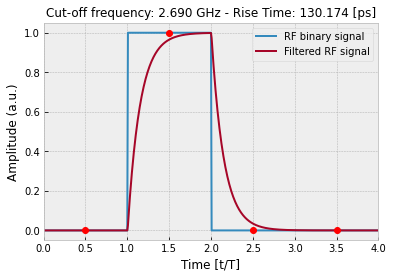

In [11]:
# Plot bits, rf signal and filtered signal
plt.figure(figsize=(6,4))
plt.plot(current.t*Rs, sigTx, label = 'RF binary signal', linewidth=2)
plt.plot(current.t*Rs, current.signal, label = 'Filtered RF signal', linewidth=2)
plt.plot(t[int(SpS/2)::SpS]*Rs, bitsTx, 'ro')
plt.title('Cut-off frequency: %.3f GHz - Rise Time: %.3f [ps]'%(1e-9*f_cut,2.2*R*C*1e12), fontsize=12)
plt.ylabel('Amplitude (a.u.)')
plt.xlabel('Time [t/T]')
plt.xlim([0,4])
plt.legend(loc='upper right')
plt.grid(True)

In [12]:
# Solve rate equations
laser_dfb_parameters,current,sol = laser.laser_dfb(laser_dfb_parameters,current)
out = laser.laser_dynamic_response(sol['y'], laser_dfb_parameters)

I_threshold: 18.020 mA
I_on: 49.964 mA
I_off: 20.000 mA


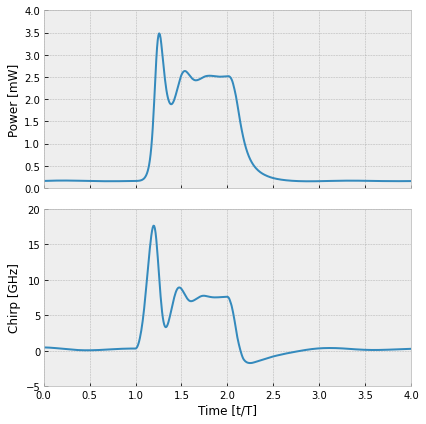

In [13]:
# Plot power and chirp. Compare with Fig. 8 from Cartledge.
fig,ax = plt.subplots(2,1,figsize=(6,6),sharex=True)
ax[0].plot(Rs*current.t,1e3*np.abs(out.e_out)**2)
ax[0].set_ylabel('Power [mW]')
ax[0].set_xlim([0,4])
ax[0].set_ylim([0,4])
ax[1].plot(Rs*current.t,1e-9*out.chirp)
ax[1].set_xlabel('Time [t/T]')
ax[1].set_ylabel('Chirp [GHz]')
ax[1].set_xlim([0,4])
ax[1].set_ylim([-5,20])
plt.tight_layout()
print('I_threshold: %.3f mA'%(1e3*laser_dfb_parameters.ith))
print('I_on: %.3f mA'%(1e3*np.real(current.signal.max())))
print('I_off: %.3f mA'%(1e3*np.real(current.signal.min())))

### Intensity modulation frequency response - See Fig. 5

#### Table I - 23, 35 and 45 mA

In [14]:
laser_23mA = laser_dfb_parameters
laser_23mA.i_bias = 0.023
laser_23mA.i_max = 0.0

laser_23mA,_,sol_23mA = laser.laser_dfb(laser_23mA,current)
out_23mA = laser.laser_dynamic_response(sol_23mA['y'], laser_23mA)

In [15]:
f = np.linspace(50e6,12e9,200)
Y0, Z0, H0 = laser.get_im_response(laser_23mA,out_23mA,f)
_, _, Ha0 = laser.get_im_response(laser_23mA,out_23mA,f,type='approx.')
# Compare these results with that presented in Table II for I_bias = 35 mA - Cartledge paper.
print("Y0 = %.3e [s^(-1)]\nZ0 = %.3e [Hz^2]\nP0 = %.3f [mW]" %(Y0, Z0, 1e3*out_23mA.power[-1]))

Y0 = 7.821e+09 [s^(-1)]
Z0 = 5.971e+20 [Hz^2]
P0 = 0.392 [mW]


In [16]:
laser_35mA = laser_dfb_parameters
laser_35mA.i_bias = 0.035
laser_35mA.i_max = 0.0

laser_35mA,_,sol_35mA = laser.laser_dfb(laser_35mA,current)
out_35mA = laser.laser_dynamic_response(sol_35mA['y'], laser_35mA)

In [17]:
Y1, Z1, H1 = laser.get_im_response(laser_35mA,out_35mA,f)
_, _, Ha1 = laser.get_im_response(laser_35mA,out_35mA,f,type='approx.')
# Compare these results with that presented in Table II for I_bias = 35 mA - Cartledge paper.
print("Y1 = %.3e [s^(-1)]\nZ1 = %.3e [Hz^2]\nP1 = %.3f [mW]" %(Y1, Z1, 1e3*out_35mA.power[-1]))

Y1 = 2.135e+10 [s^(-1)]
Z1 = 2.005e+21 [Hz^2]
P1 = 1.333 [mW]


In [18]:
laser_45mA = laser_dfb_parameters
laser_45mA.i_bias = 0.045
laser_45mA.i_max = 0.0

laser_45mA,_,sol_45mA = laser.laser_dfb(laser_45mA,current)
out_45mA = laser.laser_dynamic_response(sol_45mA['y'], laser_45mA)

In [19]:
Y2, Z2, H2 = laser.get_im_response(laser_45mA,out_45mA,f)
_, _, Ha2 = laser.get_im_response(laser_45mA,out_45mA,f,type='approx.')
# Compare these results with that presented in Table II for I_bias = 35 mA - Cartledge paper.
print("Y2 = %.3e [s^(-1)]\nZ2 = %.3e [Hz^2]\nP2 = %.3f [mW]" %(Y2, Z2, 1e3*out_45mA.power[-1]))

Y2 = 3.309e+10 [s^(-1)]
Z2 = 3.175e+21 [Hz^2]
P2 = 2.129 [mW]


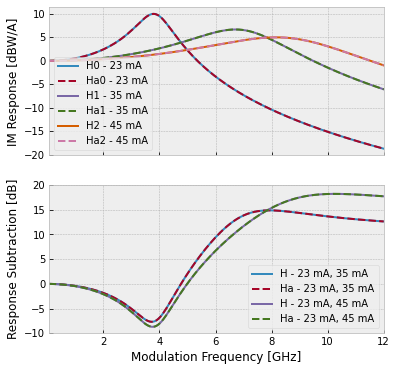

In [20]:
fig,ax = plt.subplots(2,1,figsize=(6,6),sharex=True)
ax[0].plot(1e-9*f, 20*np.log10(np.abs(H0)),label='H0 - 23 mA')
ax[0].plot(1e-9*f, 20*np.log10(np.abs(Ha0)),'--',label='Ha0 - 23 mA')
ax[0].plot(1e-9*f, 20*np.log10(np.abs(H1)),label='H1 - 35 mA')
ax[0].plot(1e-9*f, 20*np.log10(np.abs(Ha1)),'--',label='Ha1 - 35 mA')
ax[0].plot(1e-9*f, 20*np.log10(np.abs(H2)),label='H2 - 45 mA')
ax[0].plot(1e-9*f, 20*np.log10(np.abs(Ha2)),'--',label='Ha2 - 45 mA')
ax[0].set_ylabel('IM Response [dBW/A]')
ax[0].legend(loc='lower left')

# Compare with Fig. 7 of Cartledge paper.
ax[1].plot(1e-9*f, 20*np.log10(np.abs(H1)/np.abs(H0)), label = 'H - 23 mA, 35 mA')
ax[1].plot(1e-9*f, 20*np.log10(np.abs(Ha1)/np.abs(Ha0)),'--', label = 'Ha - 23 mA, 35 mA')
ax[1].plot(1e-9*f, 20*np.log10(np.abs(H2)/np.abs(H0)), label = 'H - 23 mA, 45 mA')
ax[1].plot(1e-9*f, 20*np.log10(np.abs(Ha2)/np.abs(Ha0)),'--', label = 'Ha - 23 mA, 45 mA')
ax[1].set_ylabel('Response Subtraction [dB]')
ax[1].set_xlim(1e-9*np.array([f.min(),f.max()]))
ax[1].set_ylim(-10,20)
ax[1].set_xlabel('Modulation Frequency [GHz]')
ax[1].legend(loc='lower right')

#### Frequency response fit

In [21]:
def mag_sub_ext(f,y0,z0,y1,z1):
    return 20*np.log10(np.abs(laser.im_response_hf(f,y1,z1))/np.abs(laser.im_response_hf(f,y0,z0)))

def mag_sub_app(f,y0,z0,y1,z1):
    return 20*np.log10(np.abs(laser.im_response_haf(f,y1,z1))/np.abs(laser.im_response_haf(f,y0,z0)))

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 65
    # data points      = 200
    # variables        = 4
    chi-square         = 5.5381e-26
    reduced chi-square = 2.8255e-28
    Akaike info crit   = -12682.7774
    Bayesian info crit = -12669.5842
[[Variables]]
    y0:  7.8210e+09 +/- 4.4580e-06 (0.00%) (init = 1e+10)
    z0:  5.9710e+20 +/- 120622.047 (0.00%) (init = 1e+20)
    y1:  2.1350e+10 +/- 1.1592e-05 (0.00%) (init = 5e+10)
    z1:  2.0050e+21 +/- 360354.934 (0.00%) (init = 5e+20)
[[Correlations]] (unreported correlations are < 0.500)
    C(z0, y1) = -0.6361


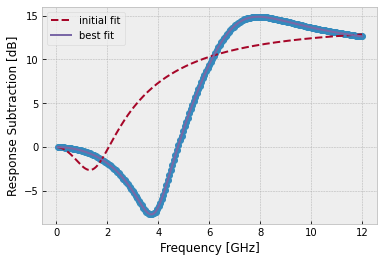

In [64]:
import lmfit

x = f
y = mag_sub_ext(f,7.821e+09,5.971e+20,2.135e+10,2.005e+21)

fit_params = lmfit.Parameters()
fit_params.add('y0', value = 1.0e10,min=1.0e9, max=1.0e11)
fit_params.add('z0', value = 1.0e20,min=1.0e19,max=1.0e22)
fit_params.add('y1', value = 5.0e10,min=1.0e9, max=1.0e11)
fit_params.add('z1', value = 5.0e20,min=1.0e19,max=1.0e22)

def myfunc(params, x, data=None):
    model = mag_sub_ext(x,params['y0'].value,params['z0'].value,params['y1'].value,params['z1'].value)
    return  model - data

mi = lmfit.minimize(myfunc, fit_params, args=(f,y), method='leastsq', nan_policy='omit')
lmfit.printfuncs.report_fit(mi, min_correl=0.5)

plt.plot(1e-9*f, y, 'o')
plt.plot(1e-9*f, myfunc(fit_params, x, y) + y, '--', label='initial fit')
plt.plot(1e-9*f, myfunc(mi.params, x, y) + y, label='best fit')
plt.xlabel('Frequency [GHz]')
plt.ylabel('Response Subtraction [dB]')
plt.legend()
plt.show()

#### Damping factor and ressonance frequency - Fig. 6

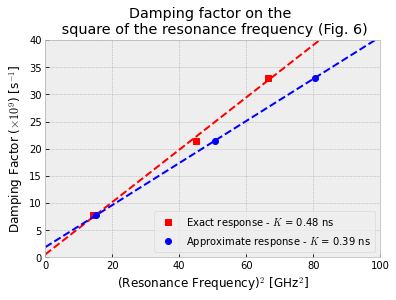

In [59]:
Z = np.array([Z0, Z1, Z2])
Y = np.array([Y0, Y1, Y2])
fr_10 = np.sqrt(Z-0.5*Y**2)/(2*np.pi)
fr_11 = np.sqrt(Z)/(2*np.pi)

coef_10= np.polyfit(fr_10**2, Y, 1)
poly1d_fn_10 = np.poly1d(coef_10) 
coef_11 = np.polyfit(fr_11**2, Y, 1)
poly1d_fn_11 = np.poly1d(coef_11) 

frq_fit = np.array([0,1e18*100])

plt.plot(1e-18*fr_10**2, 1e-9*Y, 's', color = 'r', label = 'Exact response - $K$ = %.2f ns'%(1e9*coef_10[0]))
plt.plot(1e-18*frq_fit, 1e-9*poly1d_fn_10(frq_fit), '--', color = 'r')

plt.plot(1e-18*fr_11**2, 1e-9*Y, 'o', color = 'b', label = 'Approximate response - $K$ = %.2f ns'%(1e9*coef_11[0]))
plt.plot(1e-18*frq_fit, 1e-9*poly1d_fn_11(frq_fit), '--', color = 'b')

plt.xlim([0,100])
plt.ylim([0,40])
plt.xlabel('(Resonance Frequency)$^2$ [GHz$^2$]')
plt.ylabel(r'Damping Factor ($\times 10^9$) [s$^{-1}$]')
plt.title('Damping factor on the \n square of the resonance frequency (Fig. 6)')
plt.legend()
plt.show()

### LI plot - See Fig. 14.

In [25]:
# generate pseudo-random bit sequence
bitsTx = [0, 0, 0, 0] 

# upsampling
symbolsUp = upsample(bitsTx, SpS)

# typical NRZ pulse
pulse = pulseShape('rect', SpS)
pulse = pulse/max(abs(pulse))

# pulse formatting
sigTx = firFilter(pulse, symbolsUp)

sigTx = shift(sigTx, int(SpS/2), cval=sigTx[0])
t = np.arange(0,SpS*len(bitsTx))*Ts

In [77]:
li_current = np.linspace(15e-3,50e-3,36)
laser_dfb_parameters.i_max = 0
li_power = np.zeros(len(li_current))

for i in tqdm(range(len(li_current))):
    laser_dfb_parameters.i_bias  = li_current[i]
    laser_li,_,sol = laser.laser_dfb(laser_dfb_parameters,current)
    out = laser.laser_dynamic_response(sol['y'], laser_dfb_parameters)
    li_power[i] = out.power[-1]

  0%|          | 0/36 [00:00<?, ?it/s]

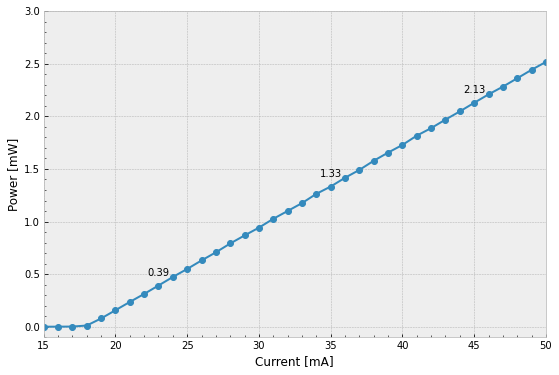

In [86]:
fig,ax = plt.subplots(figsize=(9,6))
ax.plot(1e3*li_current,1e3*li_power, 'o-')
ax.set_xlabel('Current [mA]')
ax.set_ylabel('Power [mW]')
ax.set_xlim([15,50])
ax.set_ylim([-0.1,3.0])
ax.yaxis.get_ticklocs(minor=True)
ax.minorticks_on()

xs = np.array([23,35,45])
ys = 1e3*li_power[np.array([8,20,30])]
for x,y in zip(xs,ys):
    label = "{:.2f}".format(y)
    plt.annotate(label, (x,y),
                textcoords="offset points",
                xytext=(0,10),
                ha='center')

plt.show()